In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression

import seaborn as sns
import numpy as np
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
plt.rcParams['font.size'] = 14



In [6]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z

#from lecturenotes
def gradientOLS(X,z,beta):
    n=len(z)
    return 2.0/n*X.T @ ((X @ beta)-z)

def StocGradOLS(numberMinibach,numEpochs,X,z,eta):
    betaOLS_stoc = np.random.randn(X.shape[1],1)
    MiniBachSize = int(X.shape[0]/numberMinibach)
    ##### For fixed learning rate coment in the last learningrate
    t_0 = 2 #
    t_1 = 2/(eta) #
    for i in range(numEpochs):
        for j in range(numberMinibach):
            miniBach = np.random.randint(numberMinibach)

            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t = i*numberMinibach + j #
            learningrate = t_0/(t_1 +t) #
            #learningrate = eta
            betaOLS_stoc -= learningrate *gradientOLS(X_train[miniBachMin: miniBachMax],z_train[miniBachMin:miniBachMax],betaOLS_stoc)
    return betaOLS_stoc

#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    XtX = X.T @ X
    p =np.shape(XtX)[0]
    return np.linalg.pinv(XtX +  lmb * np.identity(p)) @ X.T @ y

#This one have to be checked
def gradientRidge(X,z,beta,lam):
    n=len(z)
    return 2.0/n*X.T @ ((X @ beta)-z) + 2.0/n*lam*beta

def StocGradRidge(numberMinibach,numEpochs,X,z,eta,lam):
    betaRidge_stoc = np.random.randn(X.shape[1],1)
    MiniBachSize = int(X.shape[0]/numberMinibach)
        ##### For fixed learning rate coment in the last learningrate
    t_0 = 2 #
    t_1 = 2/(eta) #
    for i in range(numEpochs):
        for j in range(numberMinibach):
            miniBach = np.random.randint(numberMinibach)

            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t = i*numberMinibach + j #
            learningrate = t_0/(t_1 +t) #
            #learningrate = eta
            betaRidge_stoc -= learningrate *gradientRidge(X[miniBachMin: miniBachMax],z[miniBachMin:miniBachMax],betaRidge_stoc,lam)
    return betaRidge_stoc

def bootstrap_ols_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach,numEpochs,eta):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
#### we have decided to not consider the variance and bias 
    #bias = np.zeros(numberOfStraps)
    #variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaOLS = StocGradOLS(numberMinibach,numEpochs,bootX,bootz,eta)
        # Making out model and adding it to a list
        z_pred_test = X_test @ bootbetaOLS
        z_pred_train =  X_train @ bootbetaOLS
        MSEdeglisttest[i] =MSE(z_test,z_pred_test)
        MSEdeglisttrain[i]= MSE(z_train,z_pred_train)
  #      bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain)#, np.mean(bias), np.mean(variance)

def bootstrap_Ridge_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach,numEpochs,eta,lam):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
#### we have decided to not consider the variance and bias 
    #bias = np.zeros(numberOfStraps)
    #variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaRidge = StocGradRidge(numberMinibach,numEpochs,bootX,bootz,eta,lam)
        # Making out model and adding it to a list
        z_pred_test = X_test @ bootbetaRidge
        z_pred_train =  X_train @ bootbetaRidge
        MSEdeglisttest[i] =MSE(z_test,z_pred_test)
        MSEdeglisttrain[i]= MSE(z_train,z_pred_train)
   #     bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain)#, np.mean(bias), np.mean(variance)

1
2
3
4
5


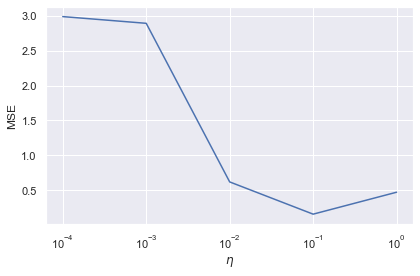

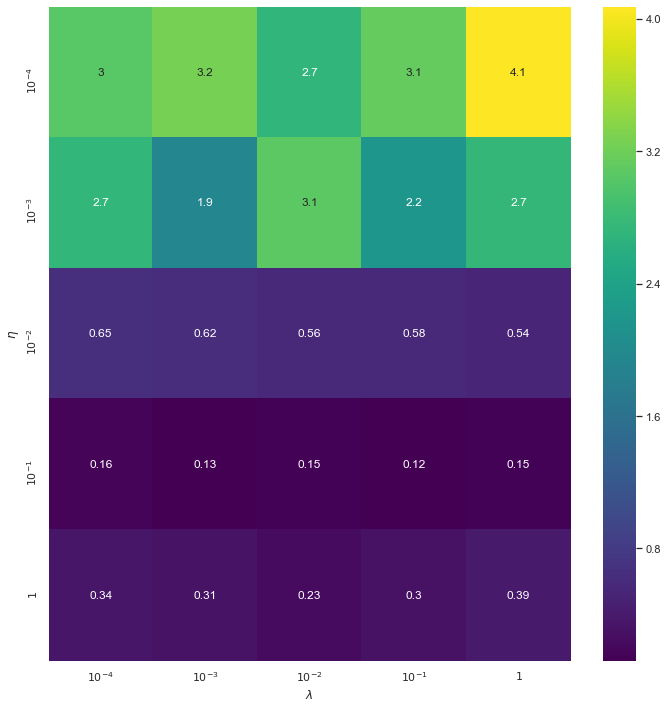

1
2
3
4
5


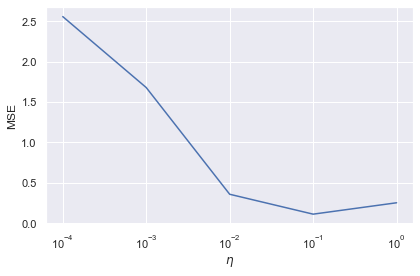

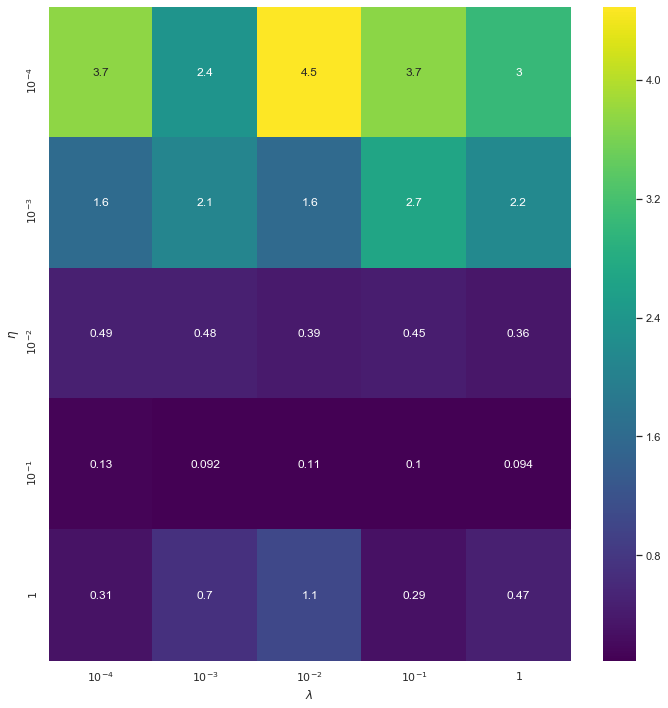

1
2
3
4
5


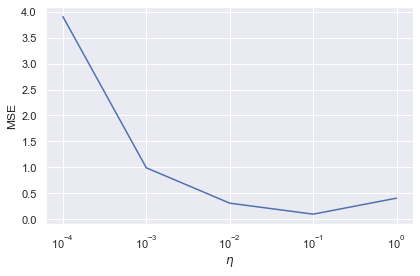

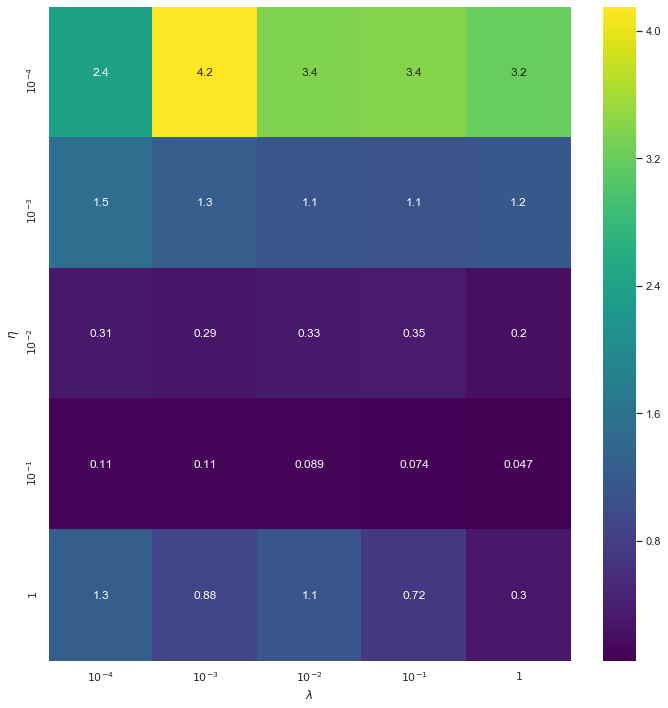

1
2
3
4
5


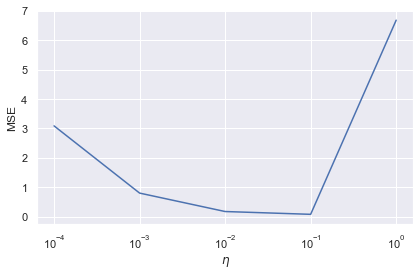

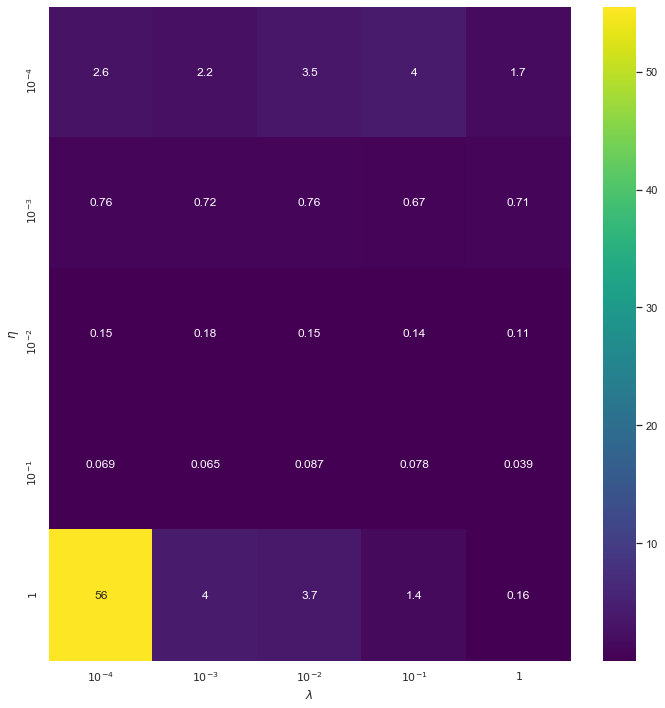

1
2
3
4
5


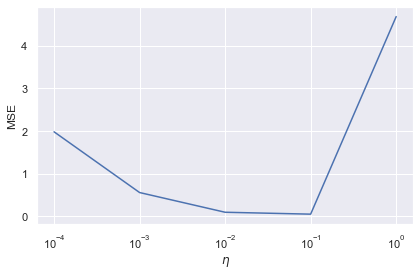

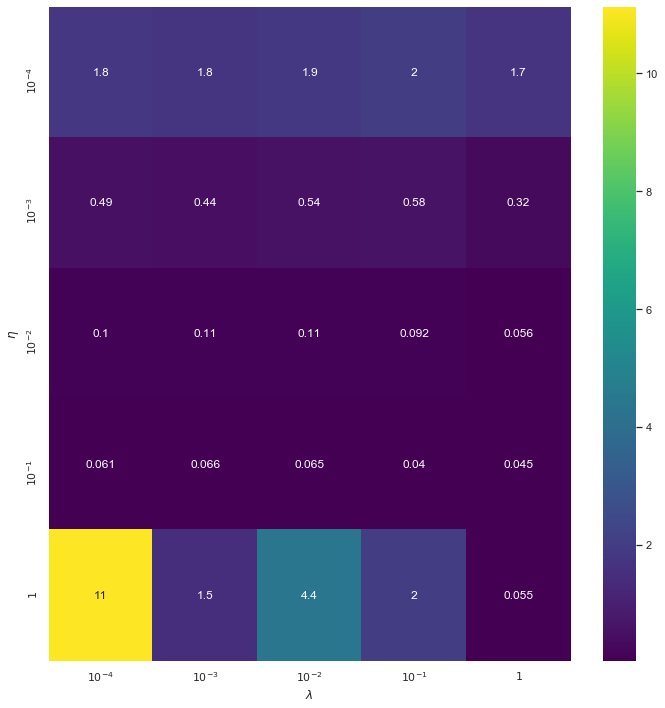

1
2
3
4
5


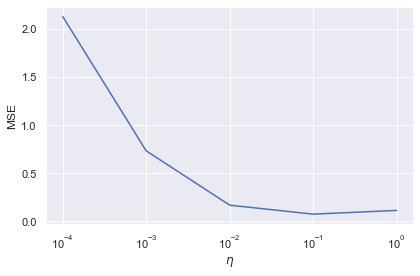

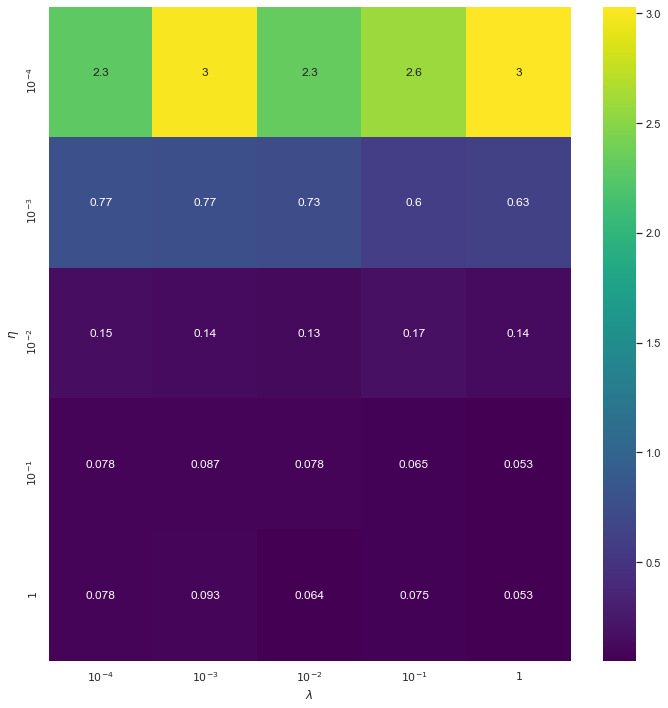

1
2
3
4
5


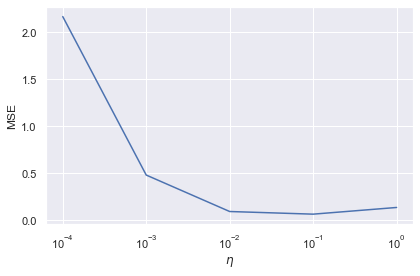

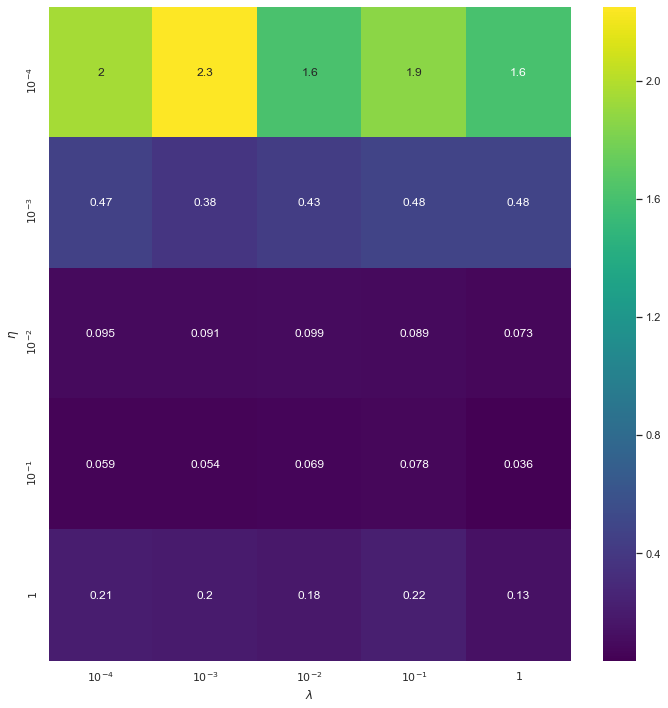

1
2
3
4
5


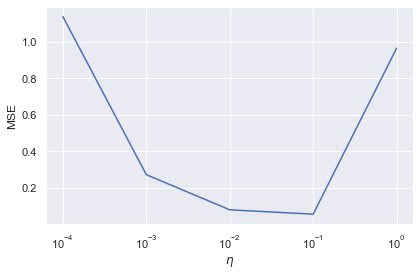

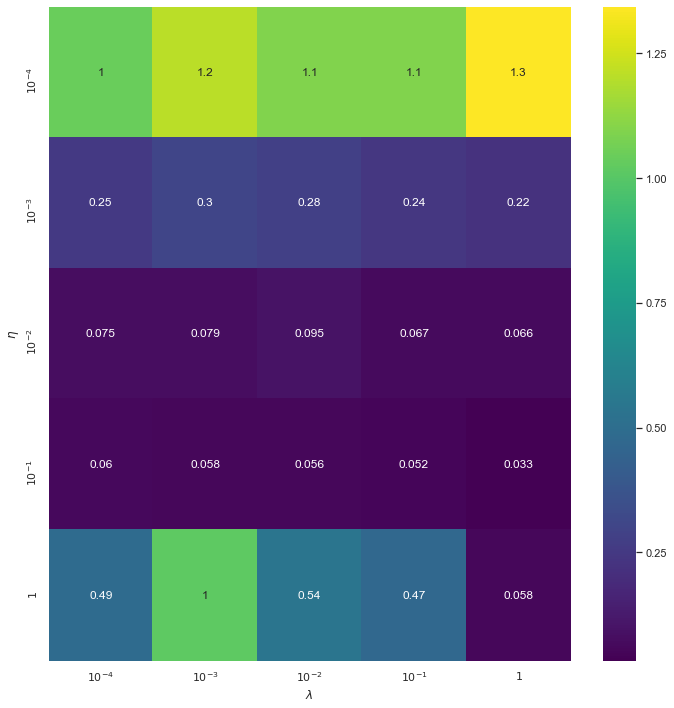

1
2
3
4
5


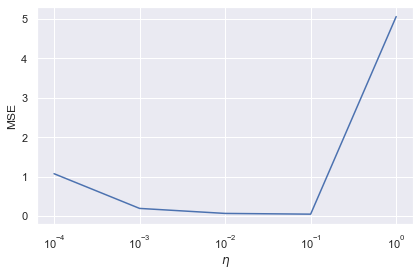

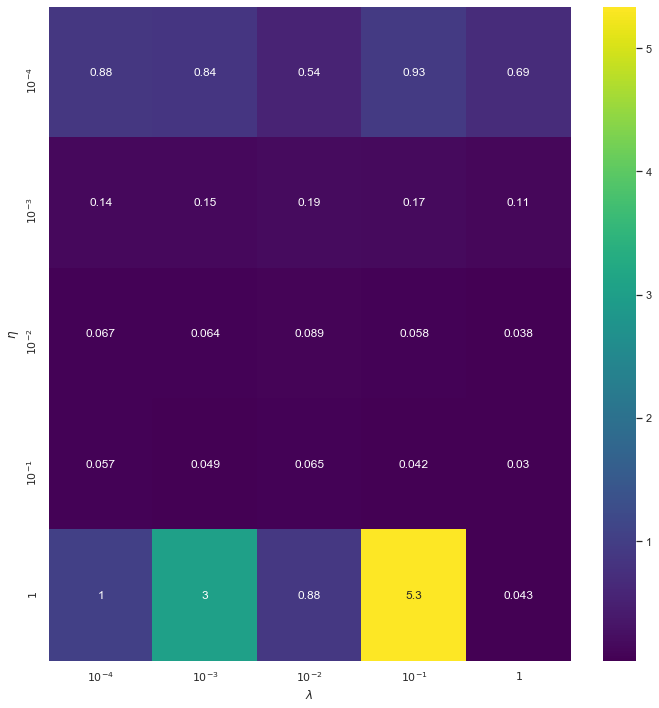

1
2
3
4
5


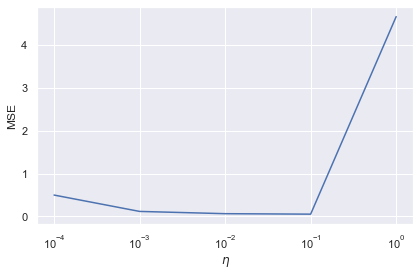

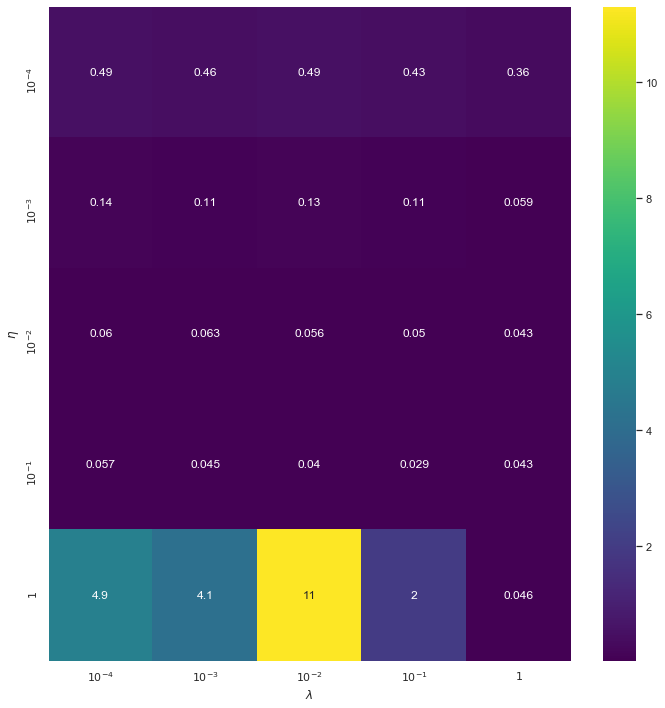

1
2
3
4
5


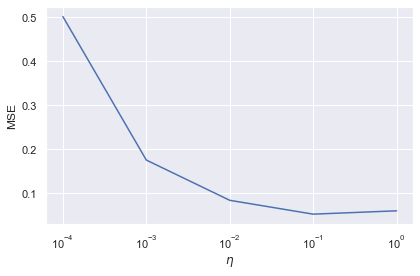

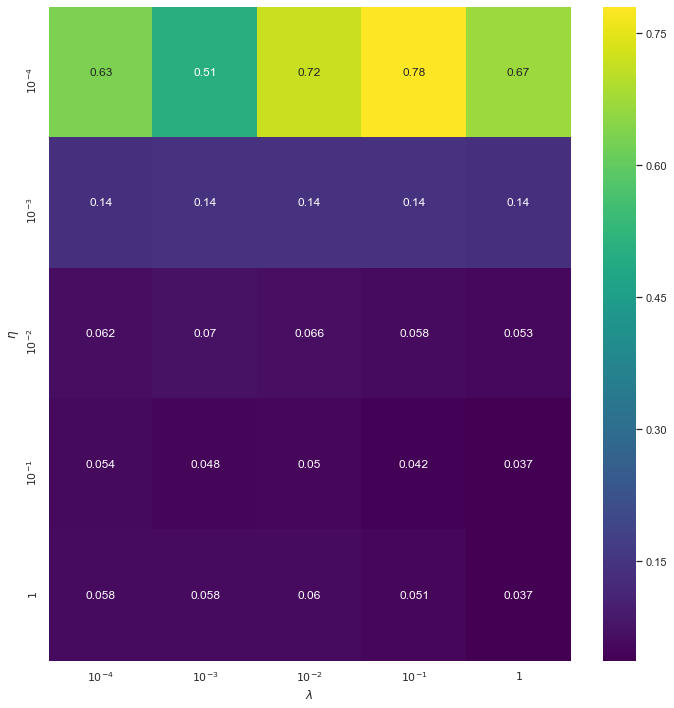

1
2
3
4
5


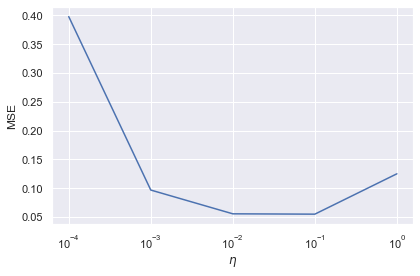

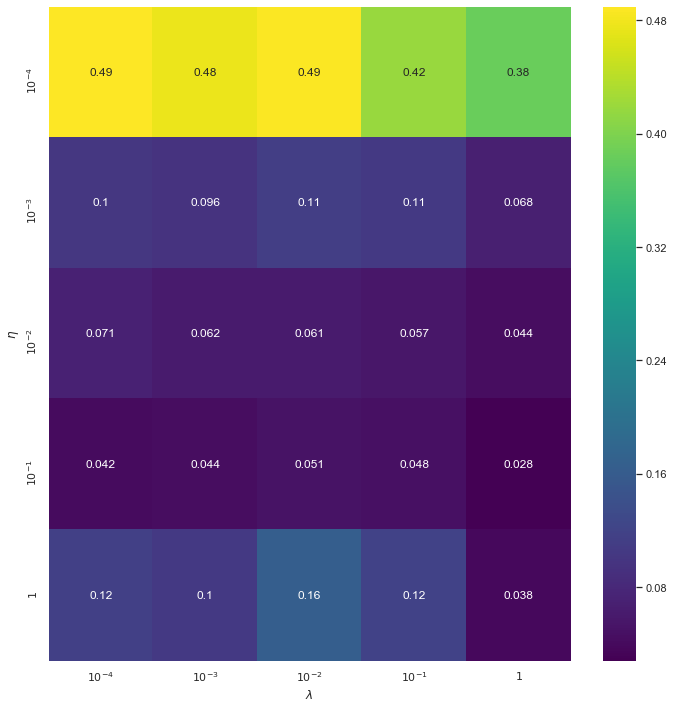

1
2
3
4
5


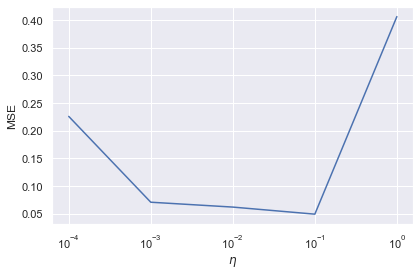

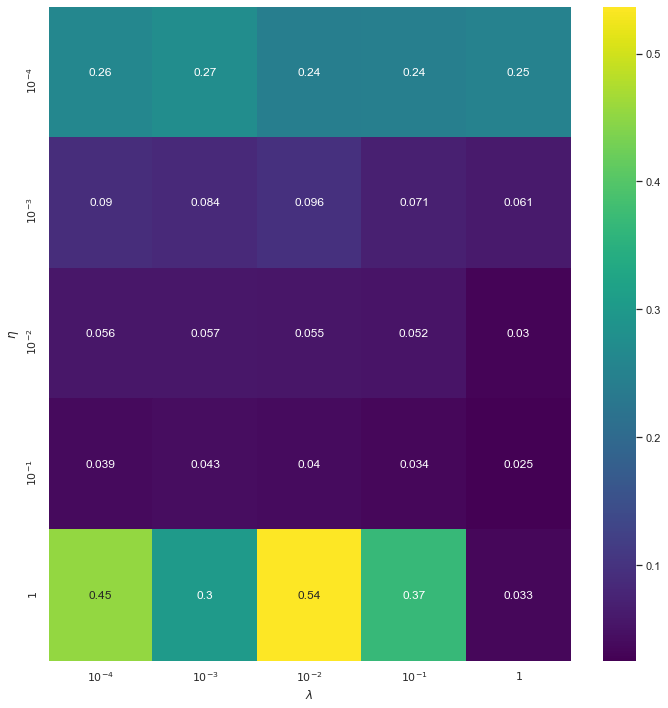

1
2
3
4
5


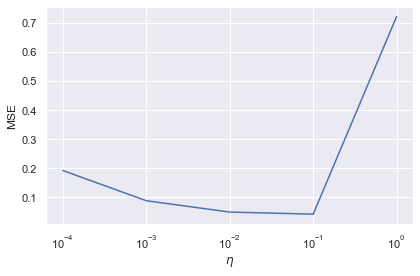

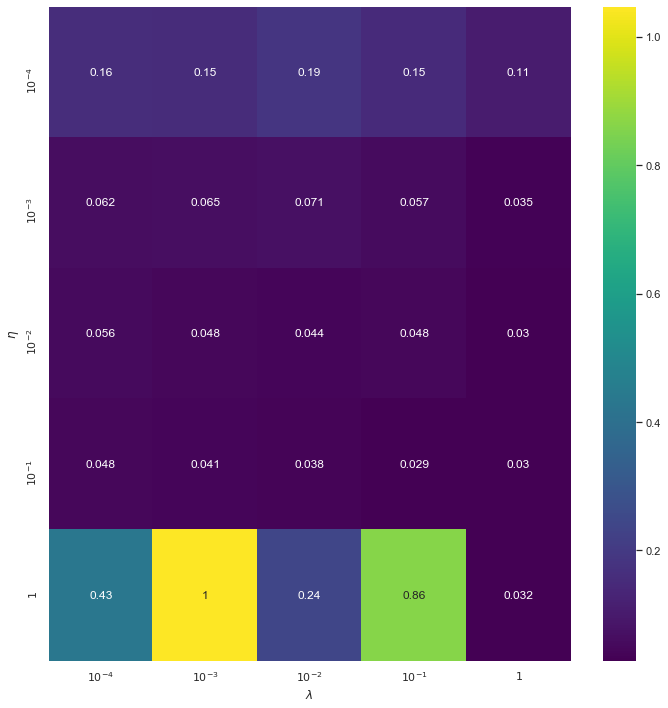

1
2
3
4
5


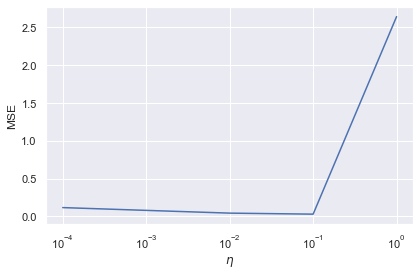

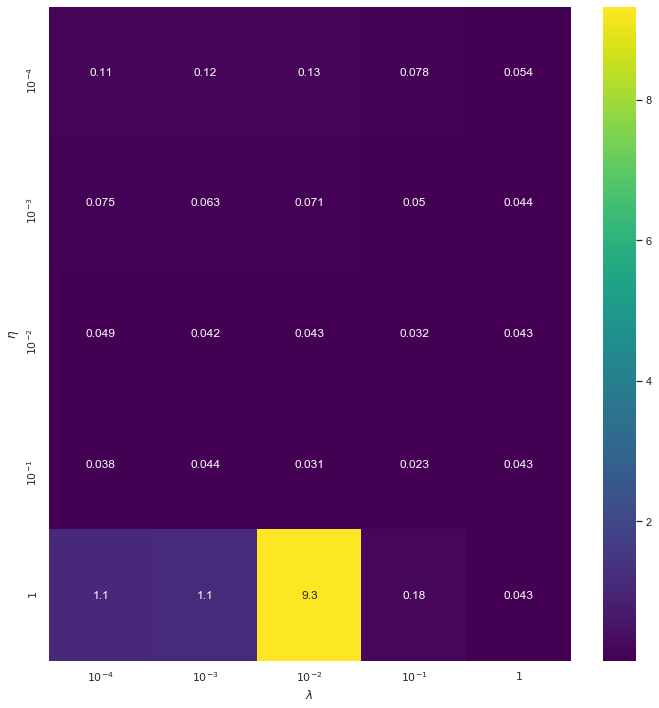

In [7]:
#First analytical expressions to compare
npoints = 20
n = 5

# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z #+ .1 * np.random.randn(npoints)

X = create_X(x,y,n)


X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)



#p = int((n+1)*(n+2)/2)

# Stocastic gradient desent, 

numberMinibach = np.array([4,8,16,32,64])
numEpochs = np.array([10,100,1000])
#epoch_index, minibach_index = 0,3 
etas = np.logspace(-4,0,5)
lambdas = np.logspace(-4,0,5)
numberOfStraps = 30

for epoch_index in range(len(numEpochs)):
    for minibach_index in range(len(numberMinibach)):
        MSE_OLS = np.zeros(len(etas))
        MSE_Ridge = np.zeros((len(etas),len(lambdas)))

        i,j = 0,0
        for eta in etas:
            for lam in lambdas:
              #  beta_Ridge_stoc = StocGradRidge(numberMinibach[1],numEpochs[0],X_train,z_train,etas[i],lamdas[j])
              #  z_pred_ridge = X_test @ beta_Ridge_stoc
              #  MSE_Ridge[i,j] = MSE(z_test,z_pred_ridge)
                MSE_Ridge[i,j],train_MSE = bootstrap_Ridge_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach[minibach_index],
                                                                numEpochs[epoch_index],eta,lam)
                j +=1
          #  beta_OLS_stoc =  StocGradOLS(numberMinibach[1],numEpochs[0],X_train,z_train,etas[i])
          #  z_pred_OLS = X_test @ beta_OLS_stoc
          #  MSE_OLS[i] = MSE(z_test,z_pred_ridge)
            MSE_OLS[i],train_MSE = bootstrap_ols_stoc(X_train,X_test,z_train,z_test,numberOfStraps,numberMinibach[minibach_index],
                                                      numEpochs[epoch_index],eta)
            i += 1
            print(i)
            j=0

        plt.figure()
        plt.semilogx(etas,MSE_OLS)
        plt.xlabel(r'$\eta$')
        plt.ylabel('MSE')
        plt.tight_layout()
        plt.savefig(f"OLS_Task_a_adaptive_learn_NumEpochs{numEpochs[epoch_index]}_NumBach{numberMinibach[minibach_index]}_New.pdf")
        plt.show()



        sns.set()

        #### Sets a log scale on the heat plot
        tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
        tick.set_powerlimits((0,0))

        tx = [u"${}$".format(tick.format_data(x)) for x in lambdas]
        ty = [u"${}$".format(tick.format_data(x)) for x in etas]

        #lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
        #etas_sea =  [etas[i] for i in range(len(etas))]

        fig, ax = plt.subplots(figsize = (10, 10))
        sns.heatmap(data=MSE_Ridge,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r'$\eta$')
        plt.tight_layout()
        plt.savefig(f"Ridge_Task_a_adaptive_learn_NumEpochs{numEpochs[epoch_index]}_NumBach{numberMinibach[minibach_index]}_New.pdf")
        plt.show()
